---
## SARIMAX

In [1]:
import os
import pandas as pd
from itertools import product
import numpy as np
import plotly.express as px
import seaborn as sns
from useful_functions import *
from pmdarima import auto_arima
import matplotlib.pyplot as plt
from scipy.stats import shapiro
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings

# Ignorer les avertissements spécifiques
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


In [2]:
# --Chemins--
raw_data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'raw')
processed_data_path = os.path.join(os.path.dirname(os.path.dirname(os.getcwd())), 'data', 'processed')
testing_path = os.path.join(processed_data_path, 'testing.csv')
training_path = os.path.join(processed_data_path, 'training.csv')
stores_path = os.path.join(raw_data_path, 'stores.csv')
# --Tables--
train = pd.read_csv(training_path,parse_dates=['date'])
train['date'] = pd.to_datetime(train['date'], format='%Y-%m-%d')

test = pd.read_csv(testing_path)
test['date'] = pd.to_datetime(test['date'], format='%Y-%m-%d')


/var/folders/db/swcwxrj54c30_jn72llv15kh0000gn/T/ipykernel_24850/2666443000.py:8: DtypeWarning: Columns (11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv(training_path,parse_dates=['date'])
/var/folders/db/swcwxrj54c30_jn72llv15kh0000gn/T/ipykernel_24850/2666443000.py:11: DtypeWarning: Columns (11,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  test = pd.read_csv(testing_path)


In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1972674 entries, 0 to 1972673
Data columns (total 20 columns):
 #   Column        Dtype         
---  ------        -----         
 0   id            int64         
 1   date          datetime64[ns]
 2   store_nbr     int64         
 3   family        object        
 4   sales         float64       
 5   onpromotion   int64         
 6   city          object        
 7   state         object        
 8   type          object        
 9   cluster       int64         
 10  dcoilwtico    float64       
 11  holiday_type  object        
 12  locale        object        
 13  locale_name   object        
 14  description   object        
 15  transferred   object        
 16  oil_price     float64       
 17  holiday       int64         
 18  month         int64         
 19  year          int64         
dtypes: datetime64[ns](1), float64(3), int64(7), object(9)
memory usage: 301.0+ MB


In [4]:
# -- Séries temporelles d'entraînement et de test --

# Série temporelle d'entraînement
series_train = train.groupby('date')[['sales', 'onpromotion']].sum()
series_train['oil_price'] = train.groupby('date')['oil_price'].mean()
series_train['holiday'] = train.groupby('date')['holiday'].first()
series_train = series_train.reset_index()
#series_train = series_train.set_index('date').asfreq('D')

# Série temporelle de test
series_test = test.groupby('date')[['sales', 'onpromotion']].sum()
series_test['oil_price'] = test.groupby('date')['oil_price'].mean()
series_test['holiday'] = test.groupby('date')['holiday'].first()
series_test = series_test.reset_index()
#series_test = series_test.set_index('date').asfreq('D')



series_train.head()

,date,sales,onpromotion,oil_price,holiday
0,2013-01-01,2511.618999,0,93.140000,1
1,2013-01-02,496092.417944,0,93.140000,0
2,2013-01-03,361461.231124,0,92.970000,0
3,2013-01-04,354459.677093,0,93.120000,0
4,2013-01-05,477350.121229,0,93.140006,1


In [5]:
series_train[['onpromotion', 'oil_price', 'holiday']].isnull().sum()

onpromotion    0
oil_price      0
holiday        0
dtype: int64

In [6]:
print(series_train.shape[0])
print(series_test.shape[0])

1092
608


### Regardons nos données

In [7]:
fig = px.line(series_train, x= 'date', y= series_train['sales'],title="Ventes global des magasins") 
fig.show()

>  La série montre des fluctuations régulières, ce qui suggère une **saisonnalité** et une **tendance sous-jacente**.

In [8]:
autocorr_values = series_train['sales'].autocorr()
print("Autocorrelation:", autocorr_values)

Autocorrelation: 0.6889804308545286


### 📊 Test de Stationnarité avec $H_0$ et $H_1$

Lorsqu'on applique un test de stationnarité (comme le test ADF - Augmented Dickey-Fuller), on cherche à déterminer si une série temporelle est stationnaire ou non. Voici comment interpréter les hypothèses :

- **$H_0$ (Hypothèse nulle)** : La série temporelle n'est **pas stationnaire** (elle possède une racine unitaire).
- **$H_1$ (Hypothèse alternative)** : La série temporelle est **stationnaire**.

### 🔍 Interprétation des résultats :
- Si la *p-value* est **inférieure** à un seuil (ex. $0.05$), on **rejette $H_0$** : la série est considérée comme stationnaire.
- Si la *p-value* est **supérieure** au seuil, on **ne rejette pas $H_0$** : la série est non stationnaire.

CE test de stationnarité est essentiel pour un model comme ARIMA,SARIMA ect... qui supposent que les données sont stationnaires.


In [9]:
test_stationnarité = adfuller(series_train['sales'])
print("ADF Statistic:", test_stationnarité[0])
print("p-value:", test_stationnarité[1])
# p-value > 0.05, la série n'est pas stationnaire


ADF Statistic: -2.188893176923171
p-value: 0.21030126102169033


### 🔄 Différenciation 

La différenciation est une technique utilisée en analyse de séries temporelles pour rendre une série non stationnaire **stationnaire**, en éliminant les tendances.

#### 📋 Formule :
$$ \text{diff}_t = y_t - y_{t-1} $$

- $y_t$ : La valeur de la série à l'instant $t$.
- $y_{t-1}$ : La valeur de la série à l'instant précédent ($t-1$).

#### 🎯 Objectif :
En appliquant cette transformation, on supprime les variations liées aux tendances ou aux composantes non stationnaires, ce qui rend la série adaptée à des modèles comme ARIMA.


In [10]:
series_train['diff'] = series_train['sales'].diff(7)
series_train = series_train.dropna(subset=['diff'])


series_train = series_train[np.isfinite(series_train['diff'])] # si valeur infini


series_train = series_train.iloc[1:] #premiere ligne contient un Nan

In [11]:
test_stationnarité = adfuller(series_train['diff'])
print("ADF Statistic:", test_stationnarité[0])
print("p-value:", test_stationnarité[1])
# p-value < 0.05, la série est stationnaire
print('ok')

ADF Statistic: -8.47929791556752
p-value: 1.4073076183564483e-13
ok


In [12]:
fig = px.line(series_train, x='date', y=['sales', 'diff'],title="Ventes globales des magasins après différenciation")
fig.show()


### 🔍 Analyse de la saisonnalité des ventes

Regardons de plus près la saisonnalité des ventes afin d'identifier les tendances récurrentes au fil du temps.


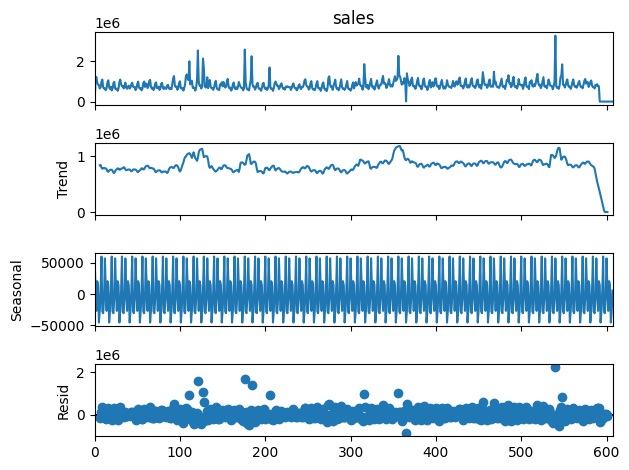

In [13]:
result = seasonal_decompose(series_test['sales'], model='additive', period=12)  # Ajustez 'period' à votre intervalle
result.plot()
plt.show()


1. **Tendance (Trend)** : 
   - Comportement global fluctuant légèrement sur le long terme.
   - Diminution récente observée.

2. **Saisonnalité (Seasonal)** : 
   - Présence de cycles réguliers indiquant une saisonnalité forte et un motif périodique clair.

3. **Résidus (Resid)** : 
   - Apparence aléatoire, indiquant que la tendance et la saisonnalité ont été correctement isolées.

#### Voyons quel model serait le plus adapté 

| Modèle      | Saisonnalité | Variables Exogènes | Quand l'utiliser                                      |
|-------------|--------------|--------------------|------------------------------------------------------|
| **SARIMAX** | Oui          | Oui                | Quand vous avez des facteurs externes qui influencent les ventes. |
| **SARIMA**  | Oui          | Non                | Quand vos données montrent une saisonnalité claire, mais sans facteurs externes. |
| **ARIMA**   | Non          | Non                | Quand vos données n'ont ni saisonnalité ni variables explicatives. |



Le modèle **ARIMA** ne gère pas la saisonnalité, donc il n'est pas recommandé ici.

##### ✅ Étapes :
1. **SARIMA** : Modélisons d'abord la saisonnalité avec un modèle adapté.
2. **SARIMAX** : Ajoutons ensuite les variables **`onpromotion`** , **`oil_price`** et **`holiday`** pour capturer l'effet des variablessur les ventes.



### 📈 Modèle SARIMA(X) : Seasonal AutoRegressive Integrated Moving Average (with Exogenous Regressors)

Le modèle SARIMAX est une extension du modèle ARIMA, qui intègre des composants saisonniers et peut inclure des variables explicatives externes, appelées **variables exogènes**.

**Variables exogènes ($X$)** : Ce sont des variables externes à la série temporelle principale, qui pourraient influencer les valeurs observées. Par exemple :
  - Les promotions ou événements spéciaux pour une série de ventes.
  - Les conditions météorologiques pour une série de consommation énergétique.
  - Les prix ou tendances économiques générales.


#### 🔍 Décomposition du modèle :
1. **AR (Auto-Régressif)** : Prend en compte la dépendance entre une observation et ses valeurs passées.
2. **I (Integrated)** : Applique une ou plusieurs différenciations pour rendre la série stationnaire.
3. **MA (Moyenne Mobile)** : Modélise l'effet des erreurs passées sur les valeurs actuelles.
4. **Saisonnière (S)** : Ajoute des termes pour capturer les motifs répétitifs (saisonnalité).
5. **X (Exogène)** : Intègre des variables explicatives externes qui influencent la série temporelle.


#### 📋 Formulation du modèle SARIMAX :
Le modèle SARIMAX peut être exprimé comme suit :
$$ y_t = SARIMA(p, d, q)(P, D, Q, s) + X_t\beta + \epsilon_t $$

- $y_t$ : Valeur de la série temporelle principale à l'instant $t$.
- $X_t\beta$ : Contribution des variables exogènes.
- $\epsilon_t$ : Terme d'erreur résiduel.

#### 🎯 Pourquoi inclure des variables exogènes ?
- **Pour améliorer la précision des prévisions** 
- **Pour expliquer des anomalies ou des pics** 





### Déterminons les paramètres du modèle


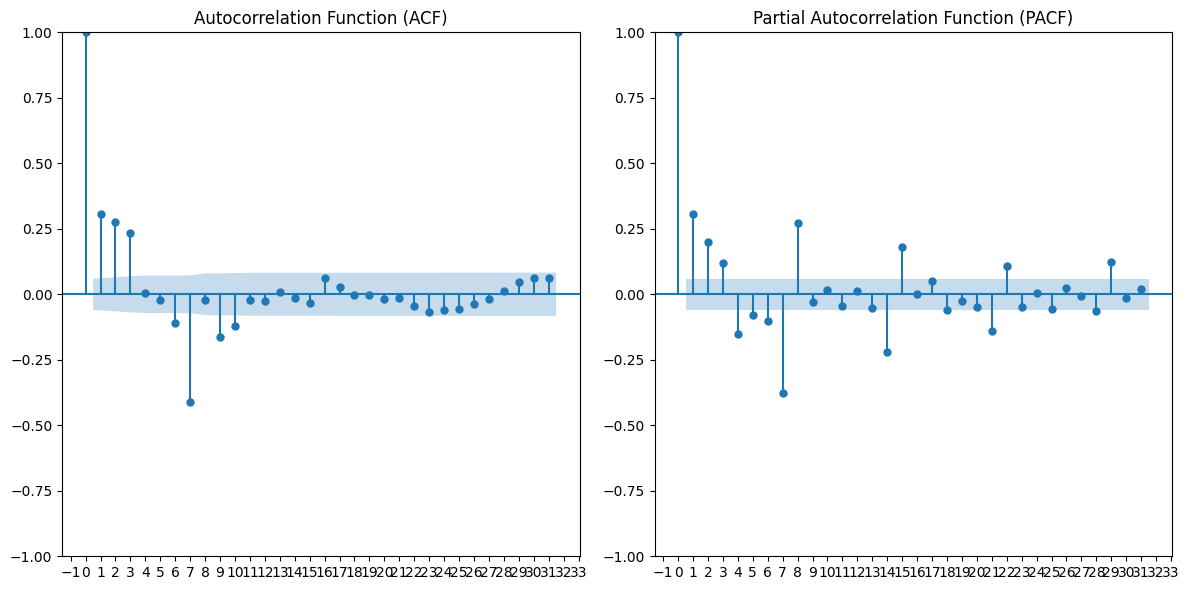

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6)) 


plot_acf(series_train['diff'],ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")
axes[0].xaxis.set_major_locator(plt.MultipleLocator(1)) 

plot_pacf(series_train['diff'], ax=axes[1], method='ywm') 
axes[1].set_title("Partial Autocorrelation Function (PACF)")
axes[1].xaxis.set_major_locator(plt.MultipleLocator(1)) 

plt.tight_layout()
plt.show()


### Tableau de reconnaissance des modèles AR, MA, ARMA

| Modèle      | ACF                                 | PACF                               |
|-------------|-------------------------------------|------------------------------------|
| AR($p$)    | Décroissance exponentielle ou sinusoïdale | Cut-off après lag $p$             |
| MA($q$)    | Cut-off après lag $q$               | Décroissance exponentielle ou sinusoïdale |
| ARMA($p, q$) | Décroissance mixte                  | Décroissance mixte                |

**Explication des termes :**
1. **Décroissance exponentielle ou sinusoïdale** : Les autocorrélations diminuent progressivement et de manière régulière.
2. **Cut-off** : L'ACF ou PACF devient presque nulle après un certain retard (lag), ce qui indique la présence de termes limités dans le modèle.

---

### Définition de l'AIC et optimisation des paramètres

L'**Akaike Information Criterion (AIC)** évalue la qualité d'un modèle statistique tout en tenant compte de sa complexité.

Formule de l'AIC :  
$$ AIC = 2k - 2\ln(L) $$  

où :
- $k$ : Nombre de paramètres estimés dans le modèle.
- $L$ : Valeur du maximum de vraisemblance du modèle.

#### Objectif :  
Minimiser l'AIC pour obtenir un modèle équilibré entre précision et complexité.

---

### Utilisation de `auto_arima` pour la sélection des paramètres

#### Étapes principales :
1. **Initialisation :**
   - Paramètres $(p, d, q)$ :
     - $p$ : termes autorégressifs (AR).
     - $d$ : degré de différenciation.
     - $q$ : termes de moyenne mobile (MA).
   - Pour les modèles saisonniers (SARIMA), on ajoute $(P, D, Q, m)$ :
     - $(P, Q, m)$ : paramètres saisonniers pour AR, MA et période ($m$).
     - $D$ : différenciation saisonnière.

2. **Itérations :**
   - Explorez toutes les combinaisons possibles de $(p, d, q)$ (et $(P, D, Q, m)$ si saisonnier).
   - Calculez l'AIC pour chaque combinaison.

3. **Sélection :**
   - Choisissez le modèle avec le plus faible AIC.



---

Ce processus sert à sélectionner le modèle le plus performant tout en évitant le sur-ajustement.


In [ ]:

auto_model = auto_arima(
    series_train['sales'],
    exog=series_train[['onpromotion', 'oil_price', 'holiday']],
    seasonal=True,
    m=7,  # Fréquence saisonnière
    trace=True,
    suppress_warnings=True
)

print(auto_model.summary())

# Meilleur modèle trouvé
print("Meilleur modèle (ordre non saisonnier et saisonnier) :")
print(f"Non saisonnier (p, d, q): {auto_model.order}")
print(f"Saisonnier (P, D, Q, m): {auto_model.seasonal_order}")

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[7] intercept   : AIC=inf, Time=1.74 sec
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=29215.743, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=28935.110, Time=0.12 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=28894.402, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=29213.757, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[7] intercept   : AIC=29006.666, Time=0.05 sec
 ARIMA(0,1,1)(1,0,1)[7] intercept   : AIC=28694.258, Time=0.46 sec
 ARIMA(0,1,1)(1,0,0)[7] intercept   : AIC=28831.416, Time=0.15 sec
 ARIMA(0,1,1)(2,0,1)[7] intercept   : AIC=28695.749, Time=0.71 sec
 ARIMA(0,1,1)(1,0,2)[7] intercept   : AIC=28696.088, Time=0.86 sec
 ARIMA(0,1,1)(0,0,2)[7] intercept   : AIC=28842.595, Time=0.47 sec
 ARIMA(0,1,1)(2,0,0)[7] intercept   : AIC=28760.991, Time=0.36 sec
 ARIMA(0,1,1)(2,0,2)[7] intercept   : AIC=28691.918, Time=1.50 sec
 ARIMA(0,1,0)(2,0,2)[7] intercept   : AIC=28937.402, Time=1.05 sec
 ARIMA(1,1,1)(2,0,2)[7] i

### Ajout de variables exogènes au modèle

Pour un modèle  **SARIMAX** (modèle ARIMA saisonnier avec variables exogènes), nous allons inclure des variables exogènes dans l’analyse. Cela permettra de mieux capturer les effets externes influençant notre série temporelle.


In [15]:
exog_vars = ['onpromotion', 'oil_price', 'holiday']
print(series_train[exog_vars].isna().sum())

onpromotion    0
oil_price      0
holiday        0
dtype: int64


>Pour être sûr, lançons une grande boucle qui teste toutes les combinaisons possibles avec un modèle SARIMAX, sélectionnons celui avec les meilleurs >
résultats, et validons les résultats d'`auto_arima`.


In [ ]:
p_values = range(0, 4)  # p
d_values = [1]  # d
q_values = range(0, 4)  # q
P_values = range(0, 2)  # P
D_values = range(0, 2)  # D
Q_values = range(0, 2)  # Q
s_values = [7]  # Période saisonnière (7 pour hebdomadaire)

file_path = "./results.json"

# Boucle sur toutes les combinaisons pour trouver le meilleursm model
for (p, d, q, P, D, Q, s) in product(p_values, d_values, q_values, P_values, D_values, Q_values, s_values):
    try:

        model_sarimax = SARIMAX(
            series_train['sales'],
            order=(p, d, q),
            seasonal_order=(P, D, Q, s),
            exog=series_train[exog_vars]
        )
        
        results = model_sarimax.fit(disp=False)
        

        forecast = results.get_prediction(
            start=series_test.index[0],
            end=series_test.index[-1],
            exog=series_test[exog_vars]
        )
        y_pred = forecast.predicted_mean
        y_true = series_test['sales']
        

        nrmse, mape, mae, r2 = calculate_metrics(y_true, y_pred)
        

        save_model_results(
            file_path=file_path,
            model_name="SARIMAX",
            params={"order": (p, d, q), "seasonal_order": (P, D, Q, s)},
            nrmse=nrmse,
            mape=mape,
            mae=mae,
            r2=r2
        )
        

    
    except Exception as e:
        print(f"Erreur avec SARIMAX({p}, {d}, {q}) x ({P}, {D}, {Q}, {s}): {e}")

# Lmeilleur modèle
with open(file_path, "r") as file:
    results = json.load(file)

# Trouver le modèle avec le meilleur NRMSE
best_model = min(results, key=lambda x: x['NRMSE'])
print("\nMeilleur modèle :")
print(json.dumps(best_model, indent=4))



Meilleur modèle :
{
    "Model": "SARIMAX",
    "Parameters": {
        "order": [
            3,
            1,
            3
        ],
        "seasonal_order": [
            1,
            1,
            1,
            7
        ]
    },
    "NRMSE": 0.14757897358481156,
    "MAPE": 6.68784899648554e+19,
    "R\u00b2": -1.6569974998649788
}


>Très légèrement différent du modèle proposé par `auto_arima` :  
>- Non saisonnier $(p, d, q) : (3, 1, 3)$  
>- Saisonnière $(P, D, Q, m) : (1, 0, 1, 7)$  
>Les résultats sont très similaires.


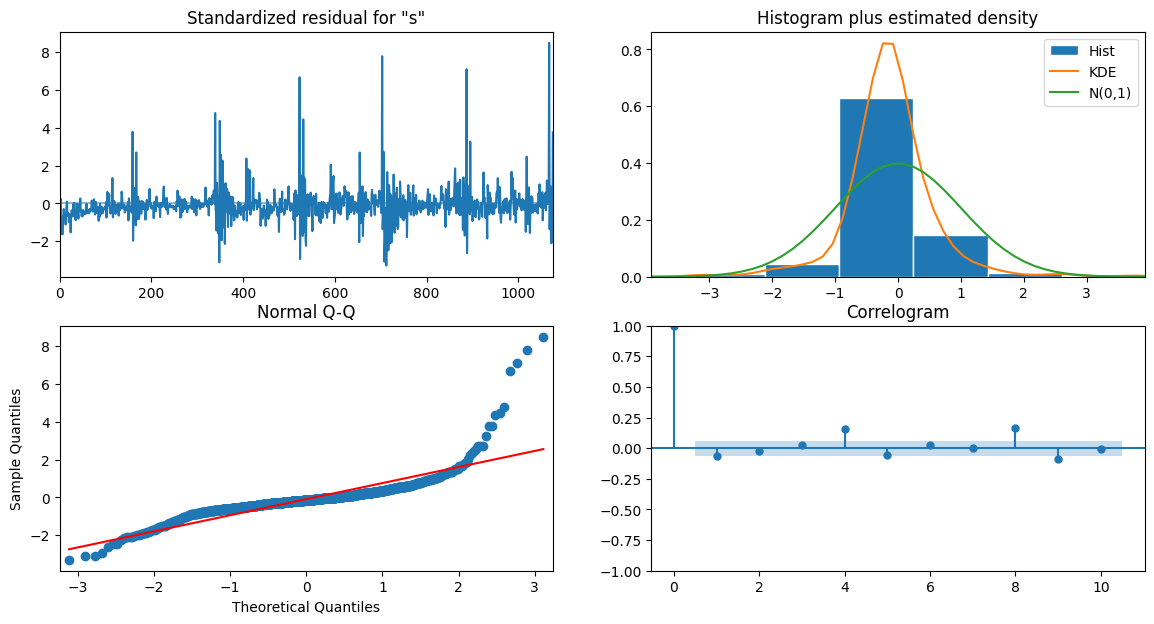

In [16]:
p, d, q = 3,1,3 # Non-saisonnier
P, D, Q, s = 1, 1, 1, 7  # Saisonnier 
y = series_train['sales']

model_sarimax = SARIMAX(y, order=(p, d, q), seasonal_order=(P, D, Q, s),exog=series_train[exog_vars])

results = model_sarimax.fit(disp=False)

results.plot_diagnostics(figsize=(14, 7))
plt.show()

In [17]:
print(results.summary())

                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                 1084
Model:             SARIMAX(3, 1, 3)x(1, 1, [1], 7)   Log Likelihood              -14133.995
Date:                             Sun, 29 Dec 2024   AIC                          28291.990
Time:                                     19:17:06   BIC                          28351.762
Sample:                                          0   HQIC                         28314.627
                                            - 1084                                         
Covariance Type:                               opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
onpromotion    53.6489      2.615     20.513      0.000      48.523      58.775
oil_price   -3110.0489  

In [18]:
#--train--
train_forecast = results.get_prediction(
    start=series_train.index[0], 
    end=series_train.index[-1],
    exog=series_train[exog_vars].iloc[:8]
)

y_train_pred = train_forecast.predicted_mean
series_train['Train_Forecast'] = y_train_pred

#--test--
forecast_steps = len(series_test) 
test_forecast = results.get_forecast(
    steps=forecast_steps, 
    exog=series_test[exog_vars]  
)


y_test_pred = test_forecast.predicted_mean
series_test['Test_Forecast'] = y_test_pred.values #pb avec les index sinon

In [19]:
fig = px.line(series_train, x='date', y=['sales', 'Train_Forecast'],title="Predictions du train")
fig.show()

In [20]:
fig = px.line(series_test, x='date', y=['sales', 'Test_Forecast'],title="Predictions du test")
fig.show()

In [21]:
nrmse, mape, mae,r2 = calculate_metrics(series_test['sales'], y_test_pred)
print(nrmse)
print(mape)
print(mae)
print(r2)

0.19945035870240035
1.7929903561246776e+20
561260.3505568438
-3.8530170619418618


### Sensibilité du MAPE et du $R^2$ aux petites valeurs

Le **MAPE** (Mean Absolute Percentage Error) et le **$R^2$** (Coefficient de détermination) sont très sensibles aux petites valeurs en raison de la division dans leurs formules.

#### Formule du MAPE
$$
\text{MAPE} = \frac{1}{n} \sum_{i=1}^n \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100
$$

- Si $y_i$ est proche de zéro, la division par $y_i$ peut entraîner une valeur aberrante.

#### Formule du $R^2$
$$
R^2 = 1 - \frac{\text{SS}_{\text{residual}}}{\text{SS}_{\text{total}}}
$$

- Si les $y_i$ sont très proches de zéro, $\text{SS}_{\text{total}}$ devient fragile, et de petites erreurs dans les prédictions peuvent provoquer un $R^2$ négatif.

Nous avons des valeurs égales à 0 ou très faibles, ce qui fait exploser ces métriques.


In [24]:
series_train.to_csv("series_train",index =False, header=True)
series_test.to_csv("series_test",index =False, header=True)

In [ ]:
data = pd.DataFrame()
data['y'] = daily_sales['sales']  # Observed value column
data = data.reset_index()
data = data.rename(columns={'date': 'ds'})
data


from prophet import Prophet

m = Prophet()
m.fit(data)

future1 = m.make_future_dataframe(periods=0)
forecast1 = m.predict(future1)
forecast1[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
daily_sales['forecast_2.1'] = forecast1['yhat'].values

In [ ]:
#lstm
import numpy as np

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 30
X_train, y_train = create_sequences(train['sales'].values, seq_length)


In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential([
    LSTM(50, activation='relu', input_shape=(seq_length, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=20, batch_size=32)


In [ ]:
#xg boost
series['lag_1'] = series['sales'].shift(1)
series['rolling_mean'] = series['sales'].rolling(7).mean()
series = series.dropna()


In [ ]:
X_train = series[['lag_1', 'rolling_mean']][:len(train)]
y_train = series['sales'][:len(train)]
X_test = series[['lag_1', 'rolling_mean']][len(train):]
y_test = series['sales'][len(train):]


In [ ]:
from xgboost import XGBRegressor

model = XGBRegressor()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


In [ ]:
#comparer les models
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
